# Imports & Initialisation

In [259]:

# ! pip install -qq PyMuPDF opencv-python numpy pandas Pillow pytesseract spacy scikit-learn
# ! pip install -qq fastapi uvicorn python-multipart

import os
import json
import re
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from io import BytesIO

# Third-party libraries
import fitz # PyMuPDF for PDF handling
import pytesseract
import spacy
from spacy.tokens import DocBin
from sklearn.metrics import classification_report

# Placeholder: FastAPI components (will be used in the final API cell)
from fastapi import FastAPI, UploadFile, File
import uvicorn

# 2. Configuration and Path Setup
# Define the root data folder
DATA_DIR = 'project_data'

# Define subdirectories for inputs, outputs, and training data
INPUT_DIR = os.path.join(DATA_DIR, 'raw_input')
CLEANED_DIR = os.path.join(DATA_DIR, 'processed_images')
TOKEN_DIR = os.path.join(DATA_DIR, 'tokens')
FINAL_REPORTS_DIR = os.path.join(DATA_DIR, 'final_reports')
CORRECTIONS_DIR = os.path.join(DATA_DIR, 'training_data_corrections')

# Create directories if they do not exist
for d in [INPUT_DIR, CLEANED_DIR, TOKEN_DIR, FINAL_REPORTS_DIR, CORRECTIONS_DIR]:
    os.makedirs(d, exist_ok=True)

# IMPORTANT: Set Tesseract path (REQUIRED if not in system PATH)
# Example for Windows: pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
# For Linux/macOS, it might just be 'tesseract' or you can omit this line if installed globally.
try:
    pytesseract.pytesseract.tesseract_cmd = 'tesseract' 
except:
    print("WARNING: Tesseract command not found. Please set the path correctly.")


# 3. Create a dummy input file for testing 
# DUMMY_PDF_PATH = os.path.join(INPUT_DIR, '17756177_50641000301.pdf')
DUMMY_PDF_PATH = os.path.join(INPUT_DIR, '97308261_Mr. MANISH BAJPIE.pdf')
if not os.path.exists(DUMMY_PDF_PATH):
    print(f"Placeholder: Create a dummy PDF at {DUMMY_PDF_PATH} for testing.")
    # In a real scenario, you would manually place a report PDF here.
    # For now, we will assume one exists for the code structure demonstration.
    
print("Setup complete. Directories created and paths defined.")

Setup complete. Directories created and paths defined.


# Module 1: File Input & Preprocessing 

In [260]:

def deskew_image(image_cv: np.ndarray) -> tuple[np.ndarray, float]:
    """Applies a simple skew correction using image moments."""
    if len(image_cv.shape) == 3:
        gray = cv2.cvtColor(image_cv, cv2.COLOR_BGR2GRAY)
    else:
        gray = image_cv

    # Simple binary mask for contour finding
    _, binary = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    coords = np.column_stack(np.where(binary > 0))
    
    if coords.size == 0:
        return image_cv, 0
        
    rect = cv2.minAreaRect(coords)
    angle = rect[-1]

    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle

    (h, w) = image_cv.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image_cv, M, (w, h),
        flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

    return rotated, angle

def preprocess_image(img_cv: np.ndarray) -> np.ndarray:
    """Applies deskewing, grayscale conversion, and OTSU thresholding."""
    if img_cv is None:
        return None

    # 1. Deskew
    deskewed_img = img_cv
    # deskewed_img, angle = deskew_image(img_cv)
    
    # 2. Convert to Grayscale
    if len(deskewed_img.shape) == 3:
        gray_img = cv2.cvtColor(deskewed_img, cv2.COLOR_BGR2GRAY)
    else:
        gray_img = deskewed_img

    # 3. Denoise and Threshold (OTSU) for optimal OCR quality
    blurred = cv2.GaussianBlur(gray_img, (5, 5), 0)
    _, final_clean_img = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    return final_clean_img

def convert_pdf_to_images(file_path: str) -> list[np.ndarray]:
    """Converts PDF pages to high-resolution OpenCV image arrays using PyMuPDF."""
    images = []
    try:
        doc = fitz.open(file_path)
        zoom = 4.16 # ~300 DPI
        matrix = fitz.Matrix(zoom, zoom)
        
        for page in doc:
            pix = page.get_pixmap(matrix=matrix, alpha=False)
            img_array = np.frombuffer(pix.samples, dtype=np.uint8).reshape(pix.h, pix.w, pix.n)
            img_cv = cv2.cvtColor(img_array, cv2.COLOR_RGB2BGR) 
            images.append(img_cv)
            
        doc.close()
    except Exception as e:
        print(f"Error processing PDF with PyMuPDF: {e}")
    return images

def process_report_file(file_path: str, output_base_name: str) -> list[str]:
    """Main function for Module 1: Handles input, preprocesses, and saves cleaned images."""
    cleaned_image_paths = []
    file_extension = file_path.lower().split('.')[-1]
    images_to_process = []

    if file_extension == 'pdf':
        print(f"Processing PDF: {file_path}")
        images_to_process = convert_pdf_to_images(file_path)
    
    elif file_extension in ['jpg', 'jpeg', 'png']:
        print(f"Processing image: {file_path}")
        img_cv = cv2.imread(file_path)
        if img_cv is not None:
            images_to_process.append(img_cv)
    
    else:
        print(f"Unsupported file type: {file_extension}")
        return []

    for i, img_cv in enumerate(images_to_process):
        cleaned_img_cv = preprocess_image(img_cv)
        
        output_filename = f"{output_base_name}_page_{i+1:02d}.png"
        output_path = os.path.join(CLEANED_DIR, output_filename) 
        cv2.imwrite(output_path, cleaned_img_cv)
        cleaned_image_paths.append(output_path)
        print(f"Saved cleaned image to: {output_path}")

    return cleaned_image_paths

## Test Module 1

Processing PDF: project_data\raw_input\97308261_Mr. MANISH BAJPIE.pdf
Saved cleaned image to: project_data\processed_images\97308261_Mr. MANISH BAJPIE_page_01.png
Saved cleaned image to: project_data\processed_images\97308261_Mr. MANISH BAJPIE_page_02.png
Saved cleaned image to: project_data\processed_images\97308261_Mr. MANISH BAJPIE_page_03.png
Saved cleaned image to: project_data\processed_images\97308261_Mr. MANISH BAJPIE_page_04.png
Saved cleaned image to: project_data\processed_images\97308261_Mr. MANISH BAJPIE_page_05.png
Saved cleaned image to: project_data\processed_images\97308261_Mr. MANISH BAJPIE_page_06.png
Saved cleaned image to: project_data\processed_images\97308261_Mr. MANISH BAJPIE_page_07.png
Saved cleaned image to: project_data\processed_images\97308261_Mr. MANISH BAJPIE_page_08.png
Saved cleaned image to: project_data\processed_images\97308261_Mr. MANISH BAJPIE_page_09.png
Saved cleaned image to: project_data\processed_images\97308261_Mr. MANISH BAJPIE_page_10.png


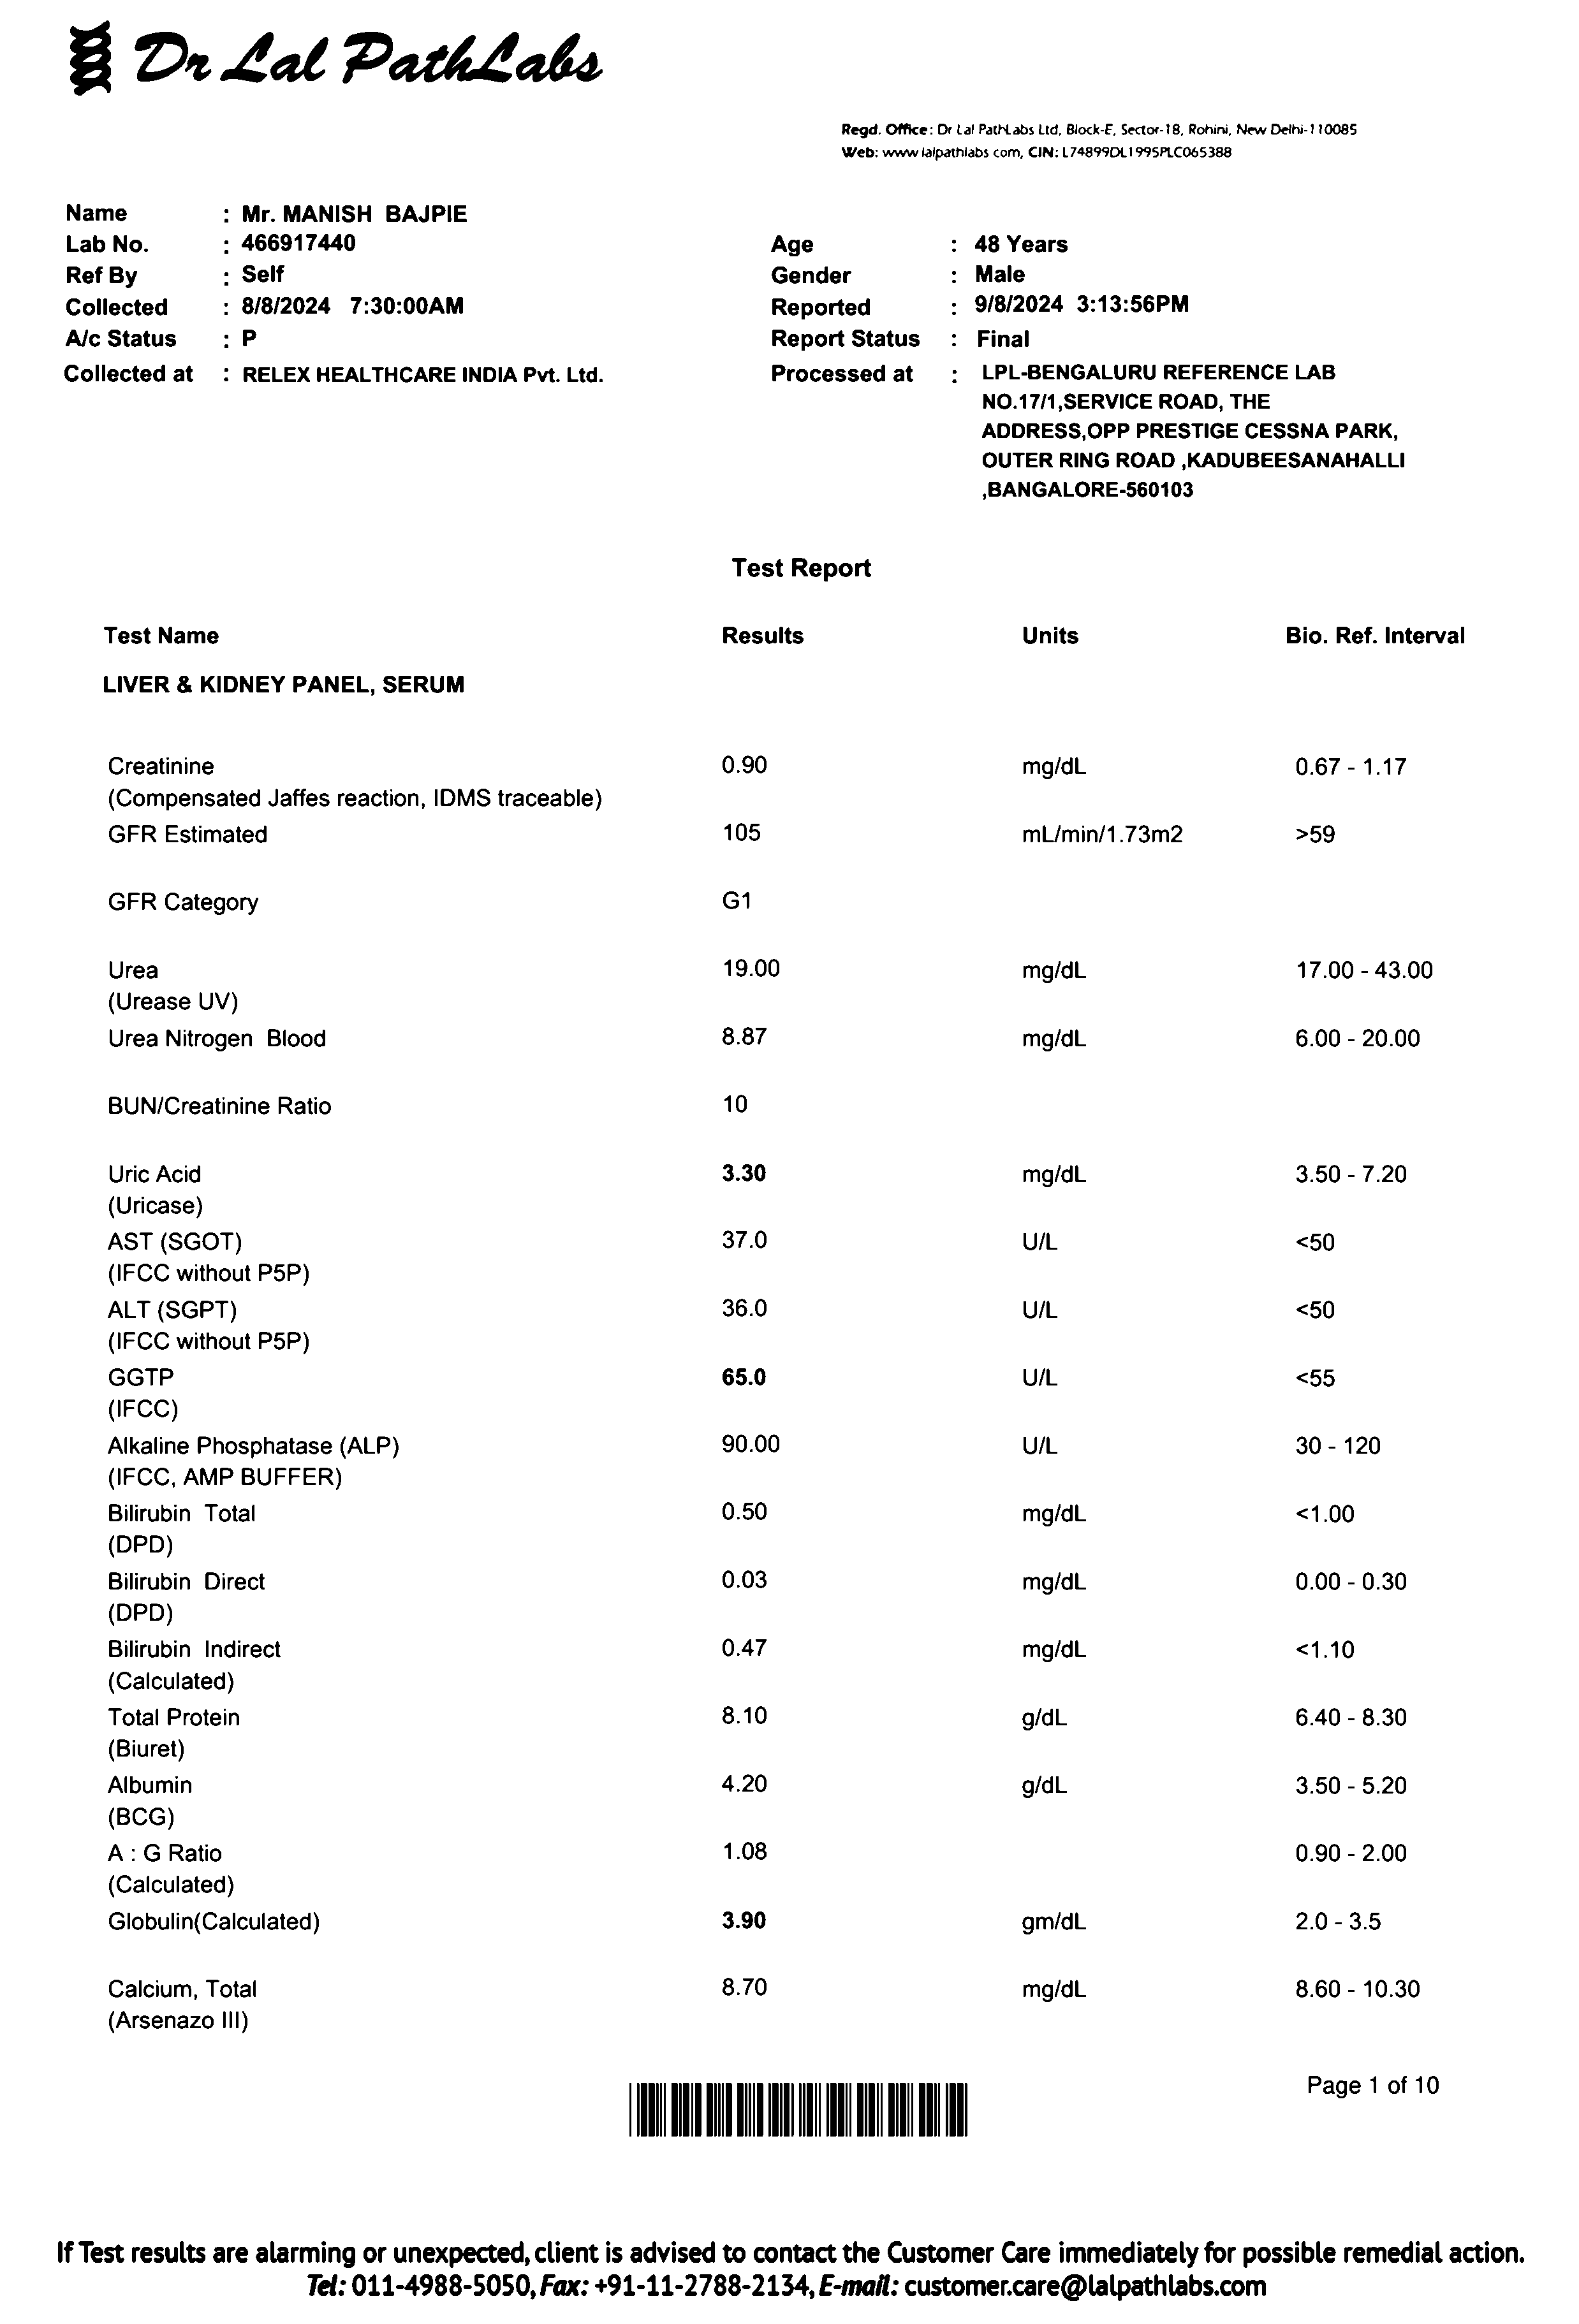

In [261]:
report_file_path = DUMMY_PDF_PATH
base_name = os.path.splitext(os.path.basename(report_file_path))[0]

if os.path.exists(report_file_path):
    cleaned_files = process_report_file(report_file_path, base_name)
    
    if cleaned_files:
        print(f"\n✅ Module 1 Success. Found {len(cleaned_files)} cleaned image(s).")
        print("Displaying the first cleaned image (Binary, Deskewed):")
        
        # Display the image in the notebook
        try:
            display_img = Image.open(cleaned_files[0])
            display(display_img)
        except Exception as e:
            print(f"Could not display image: {e}")
    else:
        print("❌ Module 1 Failed: Check file path and dependencies (PyMuPDF, Poppler).")
else:
    print("⚠️ Skipping Module 1 Test: Dummy PDF not found.")

# Module 2: OCR & Tokenisation 

In [262]:
def merge_close_tokens(tokens: list, max_gap: int = 20) -> list:
    """
    Merges adjacent tokens on the same horizontal line if the gap between them is small.
    This fixes fragmented names and compound words (e.g., "John" + "Doe" -> "John Doe").
    """
    if not tokens:
        return []
    
    merged_tokens = []
    current_phrase = tokens[0]
    
    for i in range(1, len(tokens)):
        next_token = tokens[i]
        
        # Calculate horizontal distance between tokens
        current_right = current_phrase['bbox']['left'] + current_phrase['bbox']['width']
        gap = next_token['bbox']['left'] - current_right
        
        # Check vertical alignment (y-overlap) and horizontal proximity
        y_overlap = abs(current_phrase['bbox']['top'] - next_token['bbox']['top'])
        
        # If the gap is small and they are vertically aligned (small y_overlap)
        if gap < max_gap and y_overlap < 5:
            # Merge: update text, width, and confidence (use min confidence)
            current_phrase['text'] += ' ' + next_token['text']
            current_phrase['bbox']['width'] += next_token['bbox']['width'] + gap
            current_phrase['conf'] = min(current_phrase['conf'], next_token['conf'])
        else:
            # Not mergeable, finalize the current phrase and start a new one
            merged_tokens.append(current_phrase)
            current_phrase = next_token
            
    merged_tokens.append(current_phrase)
    return merged_tokens

def run_ocr_and_tokenize(image_path: str, report_name: str) -> str:
    """Runs OCR on a cleaned image and saves word-level tokens with bboxes."""
    try:
        img_cv = cv2.imread(image_path)
        if img_cv is None:
            print(f"Error: Could not read image at {image_path}")
            return None

        # Use image_to_data to get word-level details (text, box, confidence)
        data = pytesseract.image_to_data(img_cv, output_type=pytesseract.Output.DICT)
        
        tokens_list = []
        n_boxes = len(data['level'])
        
        for i in range(n_boxes):
            # level 5 is word level
            if data['level'][i] == 5 and data['text'][i].strip():
                token = {
                    "text": data['text'][i],
                    "conf": float(data['conf'][i]) / 100, # Convert confidence to 0.0 to 1.0
                    "bbox": {
                        "left": data['left'][i],
                        "top": data['top'][i],
                        "width": data['width'][i],
                        "height": data['height'][i]
                    }
                }
                tokens_list.append(token)

        merged_tokens = merge_close_tokens(tokens_list)

        # Save tokens to a JSON file
        output_filename = f"{report_name}_tokens.json"
        output_path = os.path.join(TOKEN_DIR, output_filename)
        
        with open(output_path, 'w') as f:
            json.dump(merged_tokens, f, indent=4)
            
        print(f"Saved {len(merged_tokens)} tokens to: {output_path}")
        return output_path

    except Exception as e:
        print(f"❌ Module 2 Failed during OCR: {e}")
        return None


## Test Module 2

In [263]:
if 'cleaned_files' in locals() and cleaned_files:
    token_file_path = run_ocr_and_tokenize(cleaned_files[0], base_name)
    
    if token_file_path:
        with open(token_file_path, 'r') as f:
            tokens = json.load(f)
            
        print("\n✅ Module 2 Success. First 10 tokens extracted:")
        for token in tokens[:10]:
            print(f" - Text: '{token['text']}', Conf: {token['conf']:.2f}, BBox: {token['bbox']}")
    
else:
    print("⚠️ Skipping Module 2 Test: No cleaned image found from Module 1.")


Saved 172 tokens to: project_data\tokens\97308261_Mr. MANISH BAJPIE_tokens.json

✅ Module 2 Success. First 10 tokens extracted:
 - Text: 'BD', Conf: 0.45, BBox: {'left': 110, 'top': 32, 'width': 185, 'height': 118}
 - Text: 'Lal', Conf: 0.64, BBox: {'left': 362, 'top': 28, 'width': 150, 'height': 128}
 - Text: 'Pathlabs', Conf: 0.58, BBox: {'left': 537, 'top': 50, 'width': 408, 'height': 81}
 - Text: 'Regd. Office: Dr Lal Path', Conf: 0.61, BBox: {'left': 1320, 'top': 194, 'width': 260, 'height': 23}
 - Text: 'abs', Conf: 0.68, BBox: {'left': 1591, 'top': 189, 'width': 25, 'height': 33}
 - Text: 'Ltd, Block-E, Sector-18, Rohini, New Dethi-1 10085', Conf: 0.00, BBox: {'left': 1629, 'top': 195, 'width': 498, 'height': 18}
 - Text: 'Web: www iaipathiabs com, CIN: L74899DL', Conf: 0.54, BBox: {'left': 1320, 'top': 231, 'width': 455, 'height': 16}
 - Text: '1 99SPLC065 388', Conf: 0.34, BBox: {'left': 1768, 'top': 226, 'width': 166, 'height': 30}
 - Text: 'Name', Conf: 0.96, BBox: {'left': 

# Module 3: Rule-Based Extraction (fast baseline) 

In [264]:
def group_tokens_into_lines(tokens: list, y_tolerance: int = 10) -> list:
    """Groups OCR tokens into lines based on their vertical position."""
    if not tokens:
        return []
    
    sorted_tokens = sorted(tokens, key=lambda t: (t['bbox']['top'], t['bbox']['left']))
    
    lines = []
    current_line = [sorted_tokens[0]] if sorted_tokens else []
    
    for token in sorted_tokens[1:]:
        avg_top_current_line = sum(t['bbox']['top'] for t in current_line) / len(current_line)
        
        if abs(token['bbox']['top'] - avg_top_current_line) < y_tolerance:
            current_line.append(token)
        else:
            lines.append(sorted(current_line, key=lambda t: t['bbox']['left']))
            current_line = [token]
            
    if current_line:
        lines.append(sorted(current_line, key=lambda t: t['bbox']['left']))
        
    return lines

## Patient details

In [265]:
def extract_patient_info(lines):
    """
    Dynamically extracts key-value pairs from a list of tokenized lines.
    This is ideal for the header/patient info section.
    """
    data = {}
    
    for line in lines:
        line_text = " ".join([token['text'] for token in line])
        
        # The most common pattern is "Key : Value"
        if ':' in line_text:
            parts = line_text.split(':', 1)
            key = parts[0].strip()
            value = parts[1].strip()
            
            # Avoid adding empty keys or keys that are too long (likely not a key)
            if key and len(key) < 30:
                data[key] = value

    # Handle special cases like "Age/Gender" which might be parsed as one key
    age_gender_key = next((k for k in data if 'age' in k.lower() and 'gender' in k.lower()), None)
    if age_gender_key:
        age_gender_str = data[age_gender_key]
        if '/' in age_gender_str:
            parts = age_gender_str.split('/', 1)
            data['Age'] = parts[0].strip()
            data['Gender'] = parts[1].strip()
            del data[age_gender_key] # remove the combined key
        
    return data

## Report Details

In [266]:
import re
import json
import numpy as np
from PIL import Image



def find_table_structure(lines):
    """
    Identifies the header row and determines column boundaries by grouping header text.
    """
    header_keywords = ['test', 'investigation', 'result', 'value', 'unit', 'range']
    header_line_index = -1
    max_score = -1

    # Find the best candidate line for the header
    for i, line in enumerate(lines):
        line_text = " ".join(token['text'] for token in line).lower()
        score = 0
        if not any(char.isdigit() for char in line_text):
            score += sum(1 for keyword in header_keywords if keyword in line_text)
        if score > max_score:
            max_score = score
            header_line_index = i

    if header_line_index == -1 or max_score < 2:
        return None, None # Not a confident header

    header_line = lines[header_line_index]
    
    # Calculate average space width to distinguish between words in a header vs. new columns
    avg_char_width = np.mean([t['bbox']['width'] / len(t['text']) for t in header_line if t['text']])
    column_break_threshold = avg_char_width * 4 # Adjust if columns are too close/far

    grouped_headers = []
    current_group = []
    if header_line:
        current_group.append(header_line[0])
        for i in range(len(header_line) - 1):
            prev_token_end = header_line[i]['bbox']['left'] + header_line[i]['bbox']['width']
            next_token_start = header_line[i+1]['bbox']['left']
            
            if (next_token_start - prev_token_end) < column_break_threshold:
                current_group.append(header_line[i+1])
            else:
                grouped_headers.append(current_group)
                current_group = [header_line[i+1]]
        grouped_headers.append(current_group)

    columns = []
    for i, group in enumerate(grouped_headers):
        full_name = " ".join([t['text'] for t in group])
        start_x = group[0]['bbox']['left']
        # The end boundary is halfway to the next column's start
        if i + 1 < len(grouped_headers):
            end_x = (group[-1]['bbox']['left'] + group[-1]['bbox']['width'] + grouped_headers[i+1][0]['bbox']['left']) // 2
        else:
            end_x = 9999 # Far right for the last column
        columns.append({"name": full_name, "start_x": start_x, "end_x": end_x})
        
    return header_line_index, columns

def extract_table_rows(lines, start_index, columns, all_test_results):
    """Extracts rows from a table given the column structure."""
    current_test_name = ""
    name_col_header = columns[0]['name']

    for i in range(start_index, len(lines)):
        line_tokens = lines[i]
        line_text = " ".join([t['text'] for t in line_tokens])
        
        # Heuristic to detect end of table (e.g., summary notes, page footers)
        if "end of report" in line_text.lower() or "verified by" in line_text.lower():
            break
            
        row_data = {col['name']: "" for col in columns}
        value_present = False
        
        for token in line_tokens:
            token_center_x = token['bbox']['left'] + token['bbox']['width'] / 2
            for col in columns:
                if col['start_x'] <= token_center_x < col['end_x']:
                    row_data[col['name']] += token['text'] + " "
                    # Check if this token is a numerical value
                    if re.search(r'\d', token['text']):
                         value_present = True
                    break
        
        # Trim whitespace from all collected values in the row
        row_data = {k: v.strip() for k, v in row_data.items()}

        # Logic to handle multi-line test names
        if row_data[name_col_header] and not value_present:
            # This is likely part of a test name, not a result row
            if current_test_name:
                 current_test_name += " " + row_data[name_col_header]
            else:
                current_test_name = row_data[name_col_header]
        elif value_present:
            # This is a data row
            if row_data[name_col_header]:
                # If a name is present on this line, use it and clear any carry-over
                current_test_name = row_data[name_col_header]
            
            row_data[name_col_header] = current_test_name
            all_test_results.append(row_data)
            current_test_name = "" # Reset after use

def find_table_header_and_boundaries_dynamic(lines, image_cv):
    """
    Identifies the header row, intelligently groups multi-word headers, and finds column boundaries.
    """
    header_keywords = ['test', 'investigation', 'results', 'observed', 'value', 'unit', 'range', 'ref']
    line_scores = []

    for i, line in enumerate(lines):
        score = 0
        line_text = " ".join([token['text'] for token in line]).lower()
        if not line_text.strip():
            line_scores.append(-100)
            continue
        
        keyword_count = sum(1 for keyword in header_keywords if keyword in line_text)
        if keyword_count >= 2:
            score += keyword_count * 10
        if any(char.isdigit() for char in line_text):
            score -= 20
        line_scores.append(score)

    if not line_scores or max(line_scores) < 10:
        return None, None
        
    header_line_index = np.argmax(line_scores)
    header_line = lines[header_line_index]
    
    # Heuristic to group header tokens based on horizontal spacing
    avg_char_width = np.mean([token['bbox']['width'] / len(token['text']) for token in header_line if token['text']])
    space_threshold = avg_char_width * 5 # A large gap signifies a new column

    grouped_headers = []
    current_group = []
    if header_line:
        current_group.append(header_line[0])
        for i in range(len(header_line) - 1):
            prev_token = header_line[i]
            next_token = header_line[i+1]
            gap = next_token['bbox']['left'] - (prev_token['bbox']['left'] + prev_token['bbox']['width'])
            
            if gap < space_threshold:
                current_group.append(next_token)
            else:
                grouped_headers.append(current_group)
                current_group = [next_token]
        grouped_headers.append(current_group)

    # Define column boundaries from the grouped headers
    columns = []
    for i, group in enumerate(grouped_headers):
        full_name = " ".join([t['text'] for t in group])
        start_x = group[0]['bbox']['left']
        end_x = group[-1]['bbox']['left'] + group[-1]['bbox']['width']
        
        # Extend the boundary to the start of the next column for better token capture
        if i + 1 < len(grouped_headers):
            next_start_x = grouped_headers[i+1][0]['bbox']['left']
            end_x = (end_x + next_start_x) / 2 # Midpoint between columns
        else:
            end_x = image_cv.shape[1] # Extend to the edge for the last column
            
        columns.append({
            "name": full_name,
            "start_x": start_x,
            "end_x": end_x
        })
        
    return header_line_index, columns


## Process All Pages

In [267]:
def process_all_pages(tokens_by_page, images_by_page):
    """Orchestrates the extraction process across all pages of a report."""
    
    # 1. Get Patient Info from the first page
    page_1_tokens = tokens_by_page.get(1, [])
    page_1_lines = group_tokens_into_lines(page_1_tokens)
    patient_info = extract_patient_info(page_1_lines[:25]) # Search top part of page 1

    # 2. Find table structure and extract results from all pages
    all_test_results = []
    table_columns = None
    
    for page_num in sorted(images_by_page.keys()):
        page_tokens = tokens_by_page.get(page_num, [])
        page_image = images_by_page[page_num]
        lines_on_page = group_tokens_into_lines(page_tokens)
        
        # Try to find headers on each page, but once found, reuse them
        header_line_idx, columns = find_table_header_and_boundaries_dynamic(lines_on_page, page_image)
        
        if columns and not table_columns: # Found the first header
             table_columns = columns
        
        if table_columns: # If we have a column structure (from this page or a previous one)
            start_idx = header_line_idx + 1 if header_line_idx is not None else 0
            extract_table_rows(lines_on_page, start_idx, table_columns, all_test_results)
            
    # 3. Assemble the final JSON
    final_json = {
        "patient_info": patient_info,
        "lab_results": all_test_results,
        "metadata": {
            "extraction_method": "dynamic_rule_based_v5_grouped_headers",
            "num_tests_extracted": len(all_test_results),
            "detected_columns": [col['name'] for col in table_columns] if table_columns else "Not Found"
        }
    }
    
    return final_json

# Driver Code till Module 3

In [268]:
def test_extraction_pipeline_dynamic(file_path):
    """A wrapper function to run the full extraction process for a given file."""
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        return

    print(f"--- Processing: {os.path.basename(file_path)} ---")
    base_name = os.path.splitext(os.path.basename(file_path))[0]
    
    # Module 1: Convert PDF/Image to OpenCV images
    file_extension = os.path.splitext(file_path)[1].lower()
    images_to_process = []
    if file_extension == '.pdf':
        images_to_process = convert_pdf_to_images(file_path)
    elif file_extension in ['.png', '.jpg', '.jpeg']:
        images_to_process.append(cv2.imread(file_path))

    if not images_to_process:
        print(f"Could not read or convert file: {file_path}")
        return
        
    tokens_by_page = {}
    images_by_page = {}

    # Module 2: Run OCR on each page
    for i, img_cv in enumerate(images_to_process):
        page_num = i + 1
        cleaned_img = preprocess_image(img_cv)
        images_by_page[page_num] = cleaned_img
        
        token_data = pytesseract.image_to_data(Image.fromarray(cleaned_img), output_type=pytesseract.Output.DICT)
        
        page_tokens = []
        for j in range(len(token_data['level'])):
            if token_data['conf'][j] > -1 and token_data['text'][j].strip():
                page_tokens.append({
                    "text": token_data['text'][j],
                    "conf": float(token_data['conf'][j]),
                    "bbox": {
                        "left": token_data['left'][j], "top": token_data['top'][j],
                        "width": token_data['width'][j], "height": token_data['height'][j]
                    },
                    "page": page_num
                })
        tokens_by_page[page_num] = page_tokens
        print(f"Page {page_num}: Extracted {len(page_tokens)} tokens.")

    # Module 3: Extract structured data dynamically
    if tokens_by_page:
        print("\n--- Running Module 3: Dynamic Rule-Based Extraction ---")
        extracted_data = process_all_pages(tokens_by_page, images_by_page)
        
        print("\n Module 3 Success. Extracted Data:\n")
        print(json.dumps(extracted_data, indent=4, ensure_ascii=False))
        
        output_filename = f"{base_name}_extracted_dynamic.json"
        output_path = os.path.join(FINAL_REPORTS_DIR, output_filename)
        with open(output_path, 'w', encoding='utf-8') as f:
            json.dump(extracted_data, f, indent=4, ensure_ascii=False)
        print(f"\nSaved structured data to: {output_path}")
    else:
        print("⚠️ Module 3 failed: No tokens were extracted from the document.")

# --- Execute the test on the SATHYAVATHY report ---
# Make sure the file is in your INPUT_DIR or provide the full path.
test_extraction_pipeline_dynamic('project_data/raw_input/.pdf')
print("\n" + "="*80 + "\n")
# test_extraction_pipeline_dynamic('project_data/raw_input/97308261_Mr. MANISH BAJPIE.pdf')

File not found: project_data/raw_input/.pdf




# Module 4